Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [x] If you haven't completed assignment #1, please do so first.
- [x] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [9]:
# imports

import sys
!{sys.executable} -m pip install math
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install plotly
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install category_encoders==2.*
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from category_encoders.ordinal import OrdinalEncoder

%matplotlib inline

ERROR: Could not find a version that satisfies the requirement math (from versions: none)
ERROR: No matching distribution found for math


In [2]:
# original dataframe

basedf = pd.read_csv('../module1-define-ml-problems/data/vehicles.csv')

In [3]:
# copy dataframe for personal use

df = basedf

In [4]:
# Dropping county because it has no filled values, other columns aren't relevant
# Replacing price values of 0 with NaN - we don't want to keep these observations
# We then drop those rows

df = df.drop(['county', 'url', 'region_url', 'image_url', 'description', 'id', 'model', 'vin'], axis=1)
df['price'] = df['price'].replace(0, np.nan)
df = df.dropna(axis=0, subset=['price'])

In [5]:
# Removing ridiculous outliers (outrageously high prices and low prices to bait responses)

df = df[(df['price'] >= np.percentile(df['price'], 1)) & 
        (df['price'] <= np.percentile(df['price'], 99.9))]

In [10]:
df

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,state,lat,long
0,mohave county,3495.0,2012.0,jeep,patriot,like new,4 cylinders,gas,NaN,clean,automatic,NaN,NaN,NaN,NaN,silver,az,34.4554,-114.2690
1,oregon coast,13750.0,2014.0,bmw,328i m-sport,good,NaN,gas,76237.0,clean,automatic,NaN,rwd,NaN,sedan,grey,or,46.1837,-123.8240
2,greenville / upstate,2300.0,2001.0,dodge,caravan,excellent,6 cylinders,gas,199000.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,sc,34.9352,-81.9654
3,mohave county,9000.0,2004.0,chevrolet,colorado ls,excellent,5 cylinders,gas,54000.0,clean,automatic,1GCCS196448191644,rwd,mid-size,pickup,red,az,34.4783,-114.2710
5,maine,500.0,2010.0,NaN,$500 DOWN PROGRAMS!!!,NaN,NaN,gas,NaN,clean,automatic,NaN,NaN,NaN,NaN,NaN,me,42.8424,-71.1077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435844,mohave county,2500.0,2005.0,ford,f150,fair,NaN,gas,282866.0,clean,automatic,NaN,NaN,full-size,truck,white,az,35.2414,-113.9890
435845,rapid city / west SD,2700.0,2002.0,toyota,camry,good,6 cylinders,gas,194000.0,clean,automatic,NaN,fwd,NaN,NaN,blue,sd,44.0036,-103.3590
435846,oregon coast,2450.0,2001.0,ford,focus,good,4 cylinders,gas,130484.0,clean,automatic,NaN,rwd,compact,other,black,or,45.5272,-123.0950
435847,oregon coast,8995.0,2013.0,mazda,mazda3,NaN,NaN,gas,93339.0,clean,automatic,JM1BL1UPXD1758084,fwd,NaN,sedan,NaN,or,45.5231,-122.5790


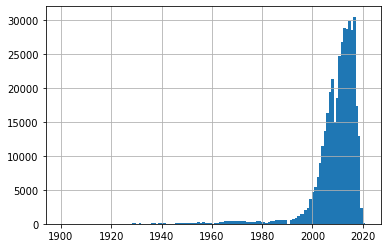

In [6]:
df['year'].hist(bins=125);

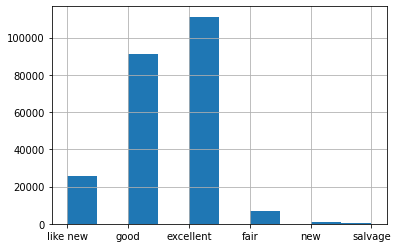

In [36]:
df['condition'].hist();

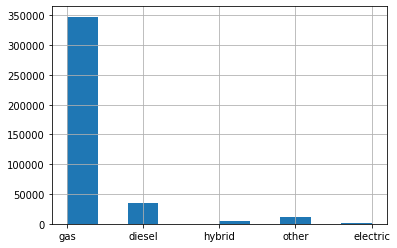

In [39]:
df['fuel'].hist();

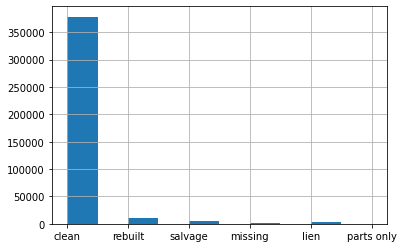

In [29]:
df['title_status'].hist();

<AxesSubplot:>

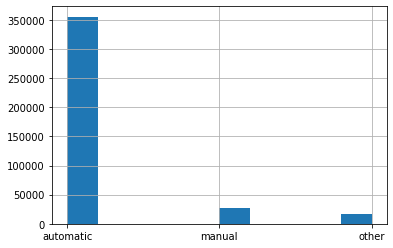

In [30]:
df['transmission'].hist();

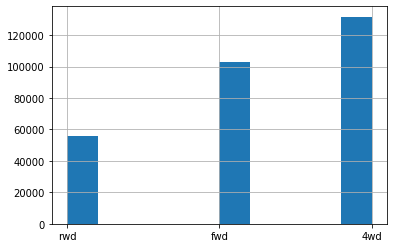

In [31]:
df['drive'].hist();

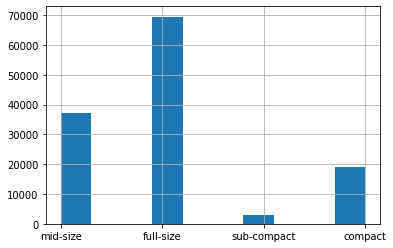

In [32]:
df['size'].hist();

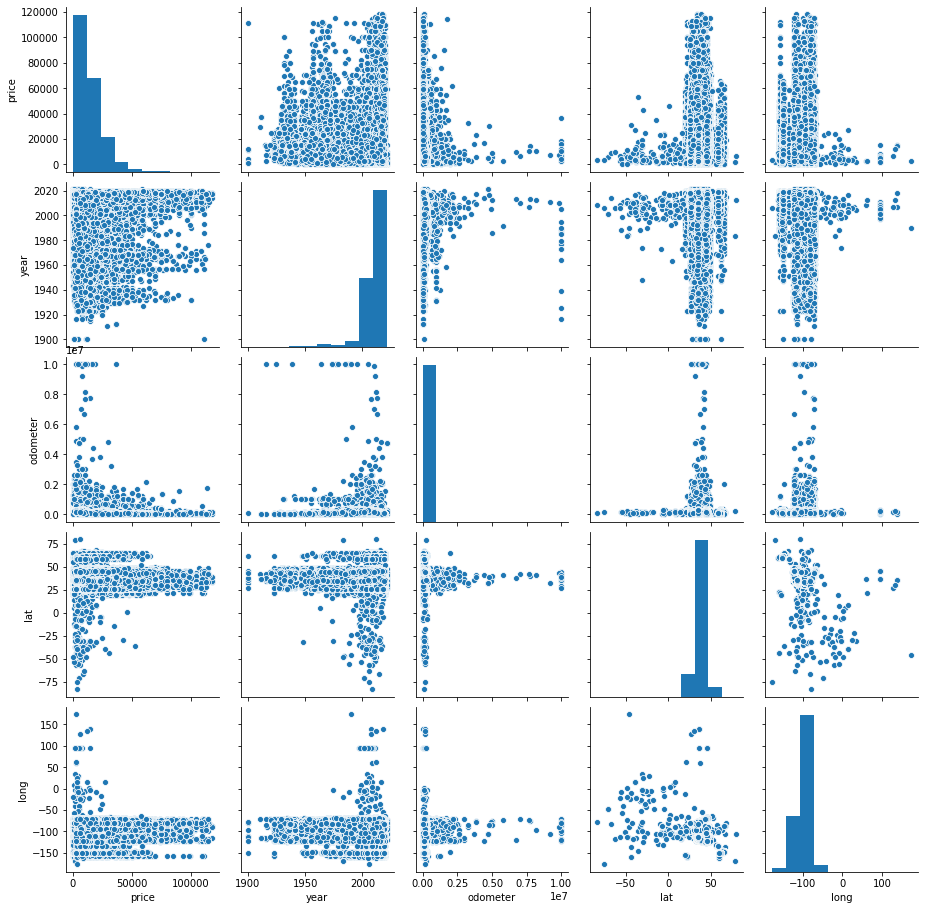

In [11]:
seaborn.pairplot(df);